In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_07_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fbae807ba20> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(2015)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

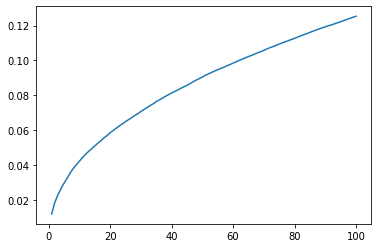

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0119, 0.0183, 0.0228, 0.0263, 0.0295, 0.0323, 0.0353, 0.0379, 0.0401,
        0.0421, 0.0442, 0.0460, 0.0478, 0.0493, 0.0509, 0.0524, 0.0539, 0.0555,
        0.0569, 0.0585, 0.0597, 0.0611, 0.0624, 0.0636, 0.0649, 0.0660, 0.0671,
        0.0683, 0.0694, 0.0706, 0.0718, 0.0729, 0.0740, 0.0751, 0.0764, 0.0773,
        0.0783, 0.0794, 0.0803, 0.0813, 0.0821, 0.0830, 0.0840, 0.0849, 0.0857,
        0.0867, 0.0877, 0.0887, 0.0895, 0.0904, 0.0914, 0.0923, 0.0931, 0.0939,
        0.0946, 0.0954, 0.0961, 0.0969, 0.0976, 0.0984, 0.0992, 0.1000, 0.1007,
        0.1015, 0.1022, 0.1029, 0.1036, 0.1043, 0.1050, 0.1058, 0.1066, 0.1073,
        0.1080, 0.1086, 0.1094, 0.1101, 0.1107, 0.1114, 0.1120, 0.1126, 0.1134,
        0.1141, 0.1148, 0.1154, 0.1161, 0.1168, 0.1174, 0.1181, 0.1187, 0.1193,
        0.1199, 0.1204, 0.1210, 0.1216, 0.1222, 0.1228, 0.1235, 0.1241, 0.1248,
        0.1254])

In [18]:
percentages.max()

tensor(0.1254)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.22742009, 0.21863319, 0.21320633, 0.20956432, 0.20701771,
       0.20481606, 0.20279551, 0.20136277, 0.19998202, 0.19878058,
       0.19766606, 0.19670875, 0.19580923, 0.19501713, 0.19437906,
       0.19368272, 0.19303113, 0.19253428, 0.19198376, 0.19148976,
       0.19097223, 0.19045021, 0.19003006, 0.18958416, 0.18918574,
       0.18880093, 0.18844003, 0.1881144 , 0.18781286, 0.18750977,
       0.18720375, 0.18692646, 0.18666436, 0.18638295, 0.18610749,
       0.18586341, 0.18562885, 0.18540104, 0.18518567, 0.18495081,
       0.18474209, 0.18451632, 0.184306  , 0.18413033, 0.18394291,
       0.18373014, 0.18353672, 0.18334263, 0.18315767, 0.18300503,
       0.18284123, 0.18267101, 0.18248316, 0.18235245, 0.18219955,
       0.18202574, 0.18188653, 0.18174468, 0.18161285, 0.18144811,
       0.18129903, 0.18117181, 0.18105303, 0.18090632, 0.18078529,
       0.18066148, 0.18054939, 0.18041568, 0.18030912, 0.18018797,
       0.18005335, 0.17992583, 0.17980076, 0.17970372, 0.17960

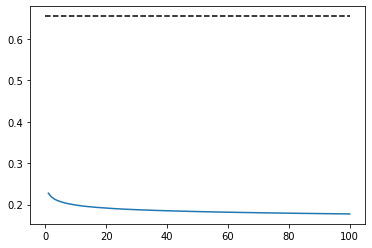

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fbad04b7900> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(1867)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.534070474881446

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0, 115754,  15062, ...,  88076, 131490, 157272],
       [     1,  23566, 140315, ..., 103411,   2445,   5374],
       [     2,  28229, 152432, ...,  70523,  39993, 156361],
       ...,
       [169340, 111061,  27580, ...,  90766,   5184,  54215],
       [169341,  67615, 121196, ...,  85072, 109659,  27339],
       [169342, 154757, 141488, ..., 162810,  16434,   2282]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.06814094976289198

In [40]:
distances

array([[1.0000002 , 0.9874357 , 0.97525454, ..., 0.94519573, 0.94494826,
        0.9449251 ],
       [1.0000001 , 0.99869484, 0.99859333, ..., 0.99492013, 0.99476254,
        0.994716  ],
       [1.        , 0.9888621 , 0.9881622 , ..., 0.9636774 , 0.9635839 ,
        0.9635793 ],
       ...,
       [1.        , 0.99881995, 0.99862075, ..., 0.997468  , 0.9974458 ,
        0.99744254],
       [0.99999976, 0.9414138 , 0.9406739 , ..., 0.87850356, 0.87840813,
        0.87837535],
       [1.0000002 , 0.96604735, 0.96431863, ..., 0.9202247 , 0.92020804,
        0.9199813 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

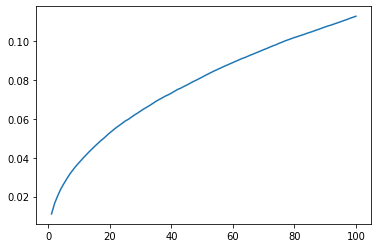

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.0110, 0.0164, 0.0204, 0.0238, 0.0266, 0.0292, 0.0317, 0.0338, 0.0358,
        0.0376, 0.0393, 0.0410, 0.0427, 0.0443, 0.0458, 0.0473, 0.0488, 0.0500,
        0.0515, 0.0529, 0.0542, 0.0555, 0.0566, 0.0578, 0.0589, 0.0598, 0.0609,
        0.0621, 0.0630, 0.0641, 0.0651, 0.0661, 0.0670, 0.0680, 0.0691, 0.0700,
        0.0708, 0.0717, 0.0724, 0.0733, 0.0742, 0.0752, 0.0758, 0.0767, 0.0774,
        0.0783, 0.0792, 0.0799, 0.0807, 0.0815, 0.0824, 0.0832, 0.0840, 0.0848,
        0.0855, 0.0862, 0.0870, 0.0877, 0.0884, 0.0891, 0.0898, 0.0904, 0.0912,
        0.0917, 0.0924, 0.0931, 0.0937, 0.0944, 0.0950, 0.0957, 0.0963, 0.0970,
        0.0976, 0.0982, 0.0990, 0.0996, 0.1002, 0.1008, 0.1014, 0.1019, 0.1024,
        0.1030, 0.1035, 0.1041, 0.1046, 0.1051, 0.1057, 0.1062, 0.1068, 0.1074,
        0.1079, 0.1084, 0.1090, 0.1095, 0.1101, 0.1106, 0.1112, 0.1118, 0.1124,
        0.1129])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.22925069, 0.22054942, 0.21470231, 0.21123105, 0.20861683,
       0.20655022, 0.20481761, 0.20326497, 0.20188677, 0.20083027,
       0.19960188, 0.19857725, 0.19783017, 0.19706833, 0.19629509,
       0.19565394, 0.19505   , 0.1944469 , 0.1938874 , 0.19341986,
       0.19298111, 0.19249447, 0.19203269, 0.19166918, 0.19128302,
       0.1908984 , 0.19049919, 0.19015359, 0.18983263, 0.18950355,
       0.18920713, 0.18891927, 0.18864313, 0.18836413, 0.18813178,
       0.18787789, 0.18765783, 0.18744004, 0.18720524, 0.18698942,
       0.1867693 , 0.18654587, 0.18629563, 0.18611997, 0.18591432,
       0.1857266 , 0.18555717, 0.18534584, 0.18512626, 0.18496011,
       0.18479306, 0.18461915, 0.1844595 , 0.18430564, 0.18411819,
       0.18396992, 0.18381825, 0.18366559, 0.1835035 , 0.18334052,
       0.18320708, 0.18307937, 0.18294812, 0.18281037, 0.18266332,
       0.18254658, 0.18241631, 0.18227425, 0.18215419, 0.18201984,
       0.1818842 , 0.18174045, 0.18162457, 0.18151334, 0.18138

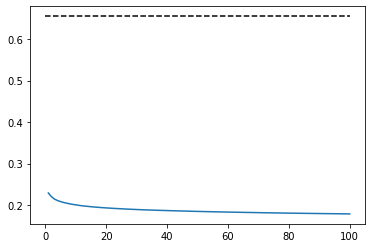

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [51]:
pca = PCA(n_components=2)

In [52]:
pca.fit(embeddings)

PCA(n_components=2)

In [53]:
emb_2d = pca.transform(embeddings)

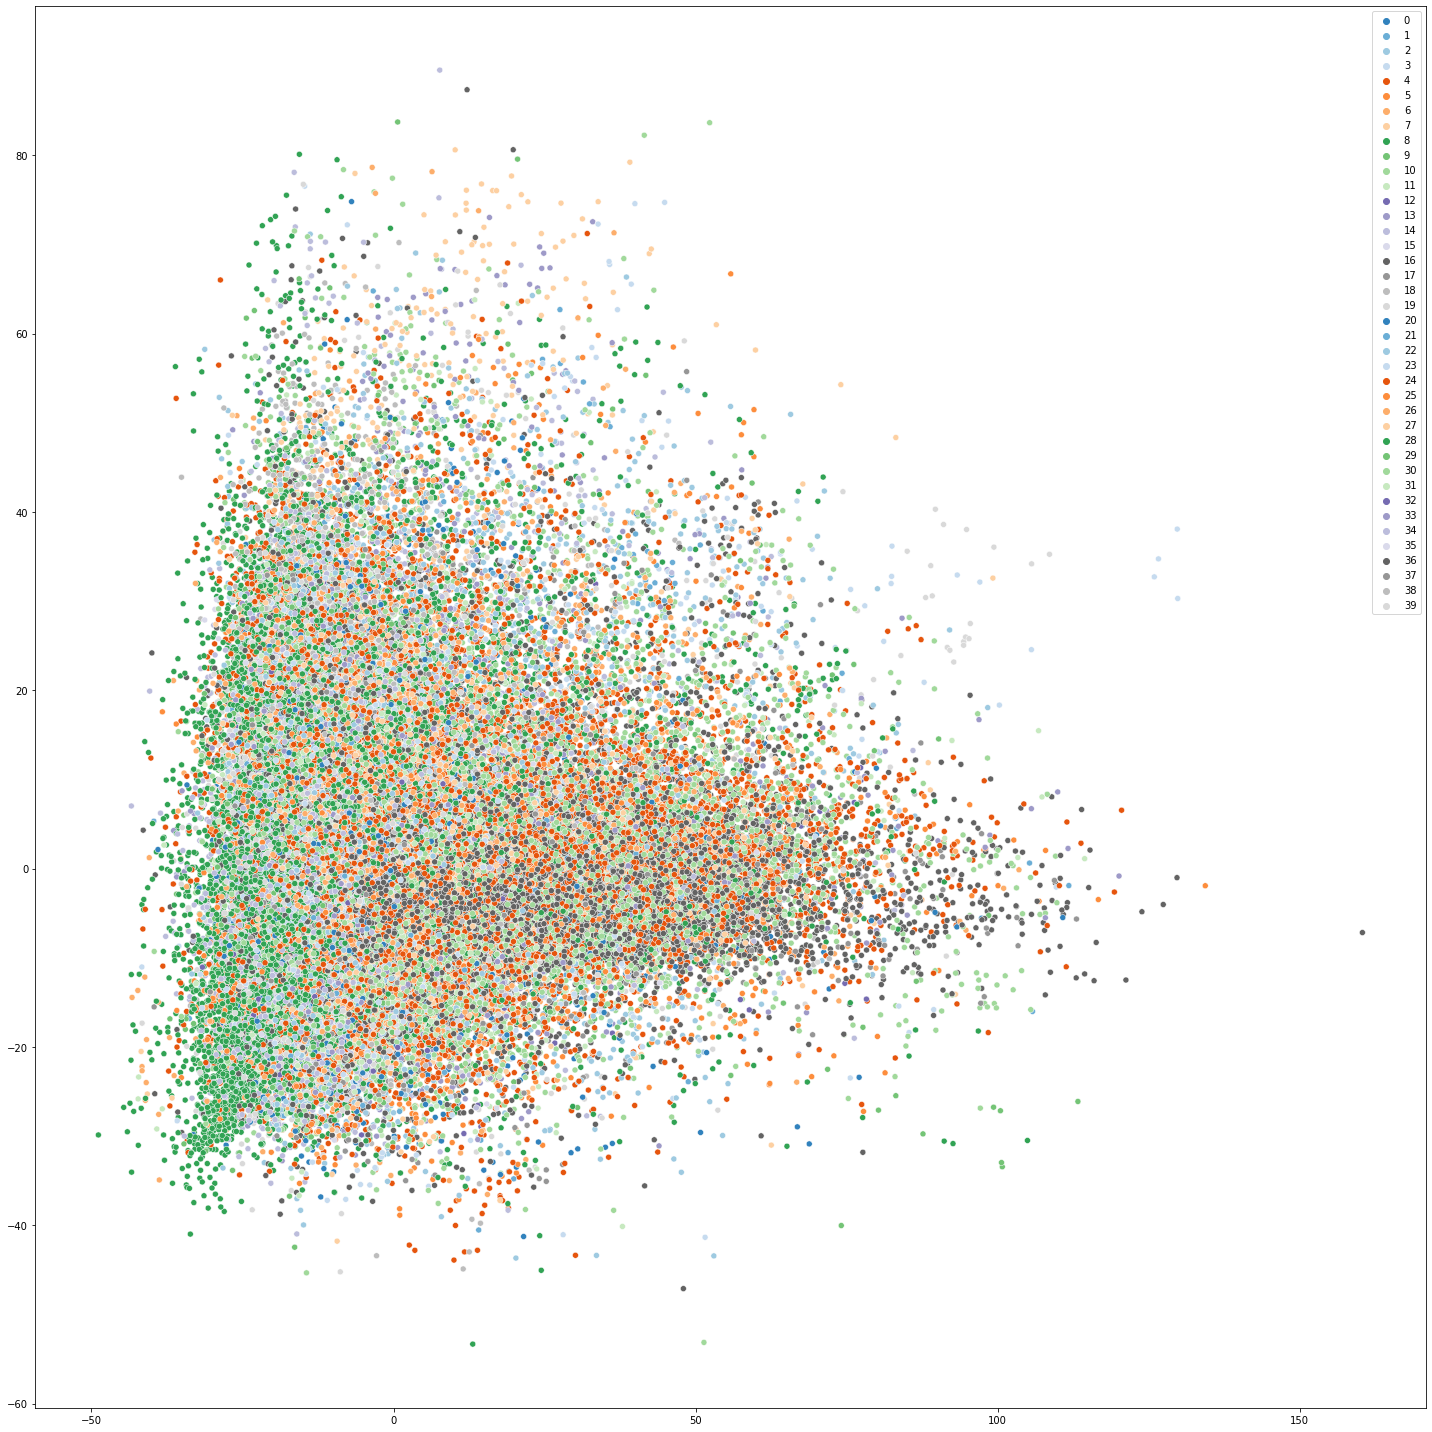

In [54]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [55]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

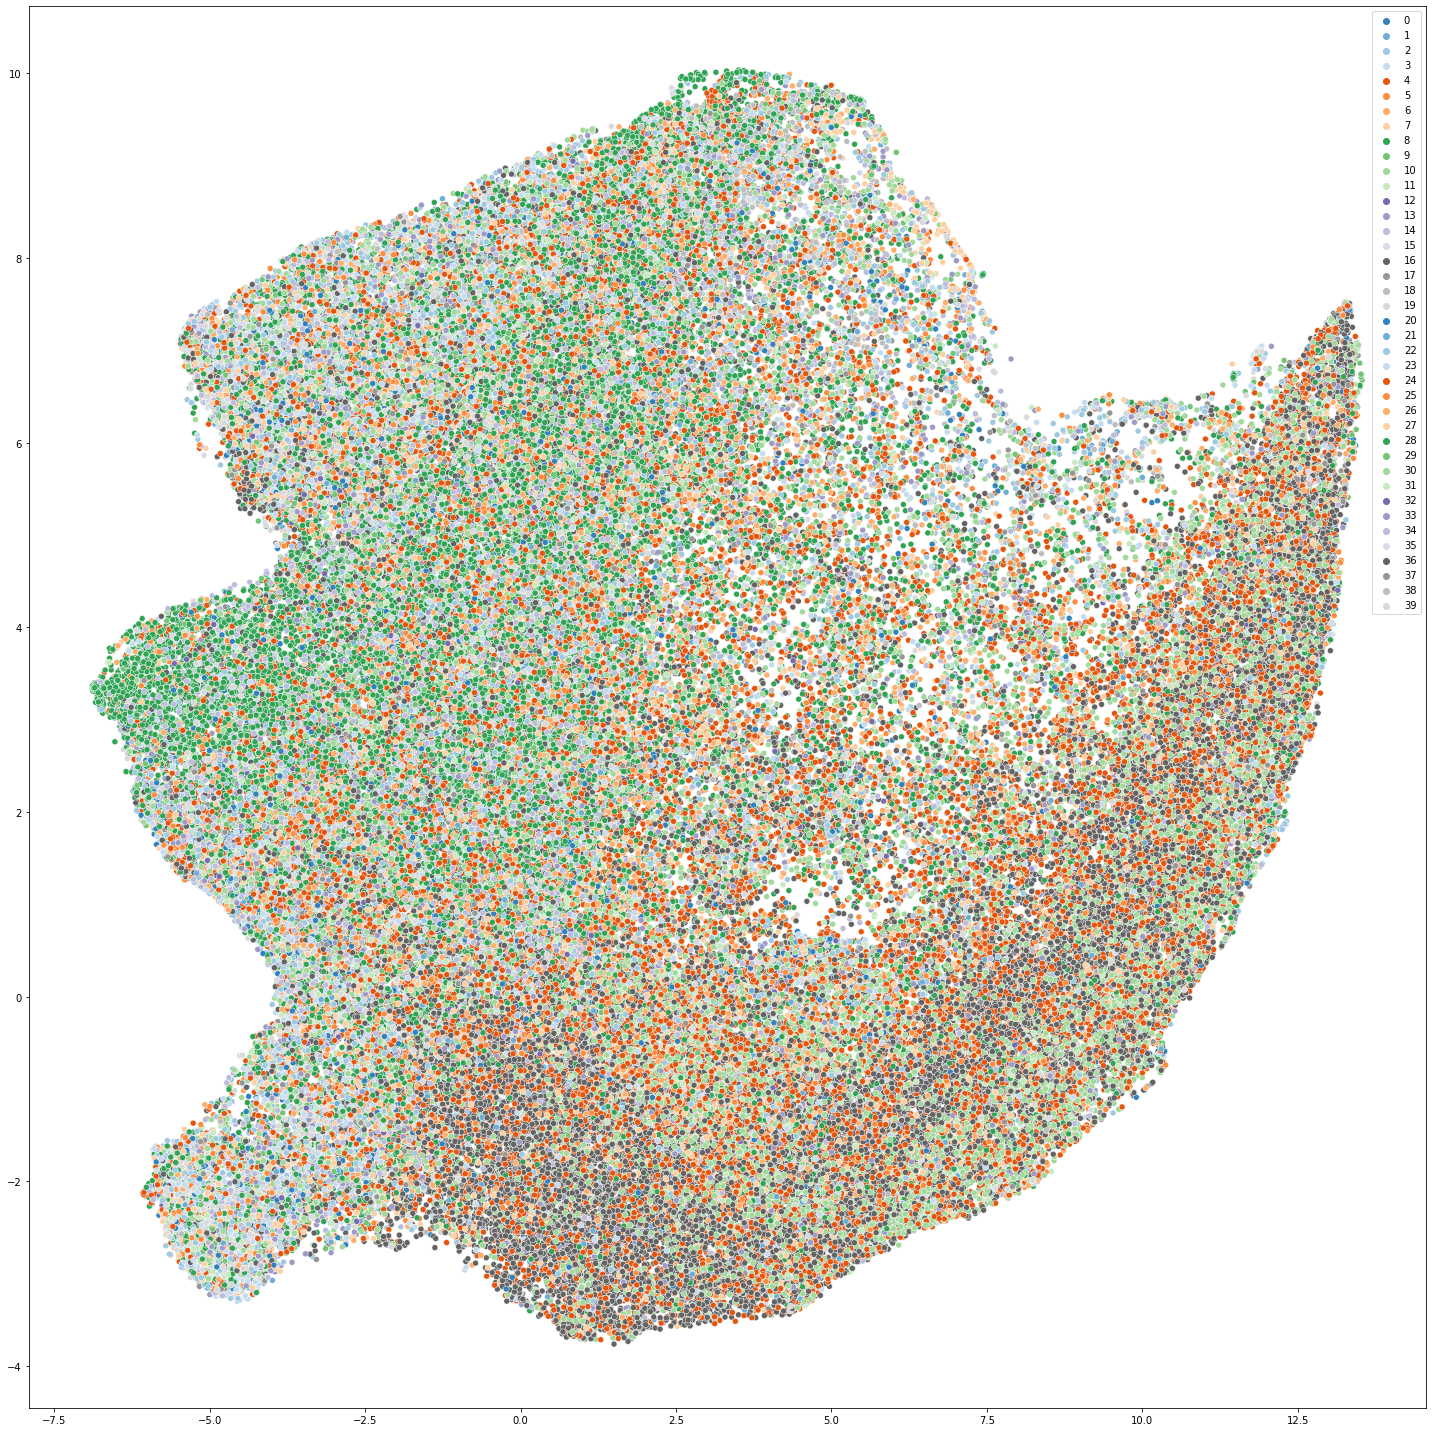

In [56]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()